In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Measurement = Base.classes.measurement
Station = Base.classes.station

In [52]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

columns = inspector.get_columns('measurement')
print(f'measurement columns ----------------')
for column in columns:
    print(column["name"], column["type"])
    
    
columns = inspector.get_columns('station')
print(f'station columns ----------------')
for column in columns:
    print(column["name"], column["type"])

measurement columns ----------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station columns ----------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [17]:
# Calculate the date 1 year ago from the last data point in the database
date_end = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date_end

('2017-08-23')

In [121]:
date_begin = dt.date(2017,8,23) - dt.timedelta(days=365)
f'{date_begin}'

'2016-08-23'

In [43]:
# Perform a query to retrieve the data and precipitation scores
measurement_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_begin).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(measurement_query)
# Sort the dataframe by date
measurement_sort_df = measurement_df.sort_values(by='date', ascending = True)
measurement_sort_df = measurement_sort_df.reset_index(drop=True)
measurement_sort_df = measurement_sort_df.dropna()
measurement_sort_df

,date,prcp
0,2016-08-23,0.00
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15
5,2016-08-23,0.70
...,...,...
2225,2017-08-22,0.00
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


Text(0.5, 0, 'Date')

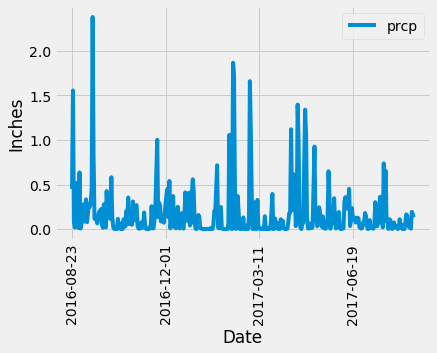

In [116]:
# Use Pandas Plotting with Matplotlib to plot the data
measurement_sort_df = measurement_sort_df.groupby('date').mean()
# plt.figure(figsize=(20, 20))
# plt.plot(measurement_sort_df)
measurement_sort_df.plot()
plt.xticks(rotation=90)
plt.ylabel("Inches")
plt.xlabel("Date")

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_sort_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [51]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [68]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count_df = pd.DataFrame(session.query(Measurement.station).all())

station_count_df['station'].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [72]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = 'USC00519281'


lowest_temp= session.query(func.min(Measurement.tobs)).filter_by(station=station_id).first()
highest_temp = session.query(func.max(Measurement.tobs)).filter_by(station=station_id).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter_by(station=station_id).all()

print(f'Lowest Temp: {lowest_temp}, Highest Temp: {highest_temp}, Average Temp: {avg_temp}')

Lowest Temp: (54.0,), Highest Temp: [(85.0,)], Average Temp: [(71.66378066378067,)]


In [80]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_high_temp = session.query(Measurement.station, Measurement.tobs).order_by(Measurement.tobs.desc()).first()
station_high_temp

('USC00519397', 87.0)

Text(0.5, 0, 'Temperature (F)')

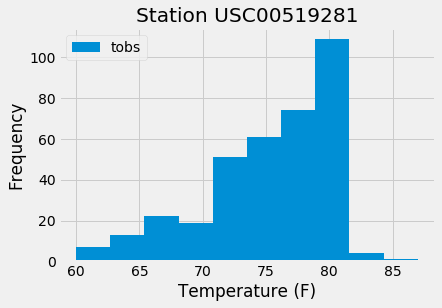

In [117]:
station_high_temp_id = 'USC00519397'

temp_query = session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.date >= date_begin)\
                .filter(Measurement.station == station_high_temp_id)\
                .all()
temp_df = pd.DataFrame(temp_query)

temp_df = temp_df.dropna()

# temp_df
temp_df.plot(kind = 'hist')
plt.title(f'Station {station_id}')
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")

## Bonus Challenge Assignment

In [101]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [102]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


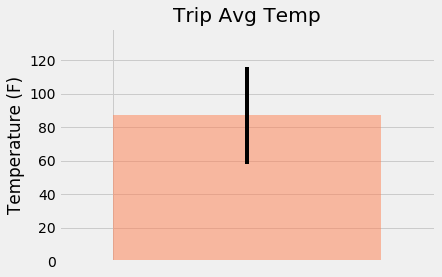

In [130]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin, tavg, tmax = calc_temps('2016-08-23', '2017-08-23')[0]
yerr = tmax - tmin

plt.bar(range(1), tmax, yerr=yerr, alpha=0.5, color='coral', align="edge")
plt.xticks(range(1), [''])
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.grid(True)
plt.margins(.2,.2)
plt.show()




In [150]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_sum = session.query(Measurement.station, func.sum(Measurement.prcp)).group_by(Measurement.station).all()
station_sum_df = pd.DataFrame(station_sum, columns = ['station', 'sum_prcp'])

station_loc_df = pd.DataFrame(session.query(Station.station, Station.name, Station.latitude,\
                                            Station.longitude, Station.elevation).all())

total_rainfall_df = pd.concat([station_sum_df, station_loc_df], axis=1)
total_rainfall_df

,station,sum_prcp,station,name,latitude,longitude,elevation
0,USC00511918,92.68,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,382.62,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,234.49,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00516128,1068.09,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00517948,43.44,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00518838,70.87,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,588.64,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00519397,131.62,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00519523,295.68,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [119]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [174]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-08-23'
end_date = '2016-08-30'

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date)\
                .filter(Measurement.date >= start_date)\
                .filter(Measurement.date <= end_date)\
                .all()
date_range
# Stip off the year and save a list of %m-%d strings
date_list = [date[0] for date in date_range]
date_md_list = [date[5:] for date in date_list]
# Loop through the list of %m-%d strings and calculate the normals for each date
date_md_list


normals = [daily_normals(date)[0] for date in date_md_list]
normals

[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.6923076

In [181]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df= pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df['date'] = date_list

normals_df.set_index('date', inplace=True)

normals_df

,tmin,tavg,tmax
date,,,
2016-08-23,67.0,76.692308,87.0
2016-08-24,70.0,75.961538,84.0
2016-08-25,69.0,76.960784,82.0
2016-08-26,71.0,76.568627,84.0
2016-08-27,68.0,76.283019,84.0
2016-08-28,67.0,76.734694,86.0
2016-08-29,70.0,76.235294,85.0
2016-08-30,68.0,76.416667,84.0
2016-08-23,67.0,76.692308,87.0


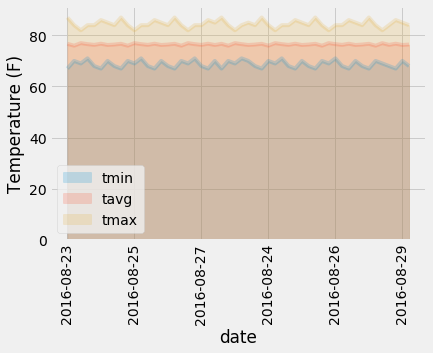

In [186]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot(kind='area', alpha=.2, stacked=False)
plt.xticks(rotation=90)
plt.ylabel(f"Temperature (F)")
plt.show()
